In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import cv2
import numpy as np
import sys
import pickle
import time
import random
import matplotlib.pyplot as plt
import matplotlib

from keras_frcnn import config
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras_frcnn import roi_helpers
from keras_frcnn import vgg as nn
from keras_frcnn import data_generators

Using TensorFlow backend.


In [2]:
def format_img_size(img, C):
    """ formats the image size based on config """
    img_min_side = float(C.im_size)
    (height, width, _) = img.shape
    
    if width <= height:
        ratio = img_min_side / width
        new_height = int(height * ratio)
        new_width = int(img_min_side)
    else:
        ratio = img_min_side / height
        new_width = int(width * ratio)
        new_height = int(img_min_side)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    return img, ratio

def format_img_channels(img, C):
    """ formats the image channels based on config """
    img = img[:, :, ::-1] # BGR -> RGB
    img = img.astype(dtype=np.float32)
    img[:, :, 0] -= C.img_channel_mean[0]
    img[:, :, 1] -= C.img_channel_mean[1]
    img[:, :, 2] -= C.img_channel_mean[2]
    img /= C.img_scaling_factor
    
#     img = np.transpose(img, (2, 0, 1)) # (channel ,height, width) ??? -> theano backend?
    img = np.expand_dims(img, axis=0)
    return img

def format_img(img, C):
    """ formats an image for model prediction based on config """
    img, ratio = format_img_size(img, C)
    img = format_img_channels(img, C)
    return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):
    real_x1 = int(round(x1 // ratio))
    real_y1 = int(round(y1 // ratio))
    real_x2 = int(round(x2 // ratio))
    real_y2 = int(round(y2 // ratio))
    return (real_x1, real_y1, real_x2, real_y2)

# Pascal dataset

In [ ]:
with open('./config.pickle', 'rb') as f_in:
    C = pickle.load(f_in)

C.use_horizontal_flips = False

class_mapping = C.class_mapping

class_mapping = {v: k for k, v in class_mapping.items()}
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

In [ ]:
num_features = 512
input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, build on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)
classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)
model_classifier = Model([feature_map_input, roi_input], classifier)
print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)
model_rpn.compile(optimizer='sgd', loss='mae')
model_classifier.compile(optimizer='sgd', loss='mae')

In [ ]:
bbox_threshold = 0.8
img_path = '/content/dohai90/datasets/pascal_data/VOCdevkit/VOC2007/JPEGImages'
img_names = sorted(os.listdir(img_path))
img_name = random.choice(img_names)
fpath = os.path.join(img_path, img_name)

In [ ]:
fpath

In [ ]:
img = cv2.imread(fpath)
X, ratio = format_img(img, C)

# get the feature maps and output from the RPN
[Y1, Y2, F] = model_rpn.predict(X)

In [ ]:
R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)

In [ ]:
# convert from (x1, y1, x2, y2) to (x, y, w, h)
R[:, 2] -= R[:, 0]
R[:, 3] -= R[:, 1]
# apply the spatial pyramid pooling to the proposed regions
bboxes = {}
probs = {}

In [ ]:
R.shape

In [ ]:
for jk in range(R.shape[0] // C.num_rois + 1):
    ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
    if ROIs.shape[1] == 0:
        break
        
    if jk == R.shape[0] // C.num_rois:
        # pad R        
        curr_shape = ROIs.shape
        target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
        ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
        ROIs_padded[:, :curr_shape[1], :] = ROIs
        ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
        ROIs = ROIs_padded
        
    [P_cls, P_regr] = model_classifier.predict([F, ROIs])
    
    for ii in range(P_cls.shape[1]):
        if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
            continue
            
        cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]
        
        if cls_name not in bboxes:
            bboxes[cls_name] = []
            probs[cls_name] = []
            
        (x, y, w, h) = ROIs[0, ii, :]
        cls_num = np.argmax(P_cls[0, ii, :])
        try:
            (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num: 4 * (cls_num + 1)]
            tx /= C.classifier_regr_std[0]
            ty /= C.classifier_regr_std[1]
            tw /= C.classifier_regr_std[2]
            th /= C.classifier_regr_std[3]
            x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
        except:
            pass
        
        bboxes[cls_name].append([C.rpn_stride * x, C.rpn_stride * y, C.rpn_stride * (x + w), C.rpn_stride * (y + h)])
        probs[cls_name].append(np.max(P_cls[0, ii, :]))

all_dets = []
for key in bboxes.keys():
    bbox = np.array(bboxes[key])
    
    new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
    for jk in range(new_boxes.shape[0]):
        (x1, y1, x2, y2) = new_boxes[jk, :]
        (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
        cv2. rectangle(img, (real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])), 2)
        textLabel = '{}: {}'.format(key, int(100 * new_probs[jk]))
        all_dets.append((key, 100 * new_probs[jk]))
        
        (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
        textOrg = (real_x1, real_y1-0)

        cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
        cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
        cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

In [ ]:
plt.figure(figsize=(10, 13))
plt.imshow(img[:, :, ::-1])
plt.show()

In [ ]:
print(all_dets)

# OCR

In [3]:
with open('./config.pickle', 'rb') as f_in:
    C = pickle.load(f_in)

C.use_horizontal_flips = False
C.model_path = './weights/model_ocr.h5'

class_mapping = C.class_mapping

class_mapping = {v: k for k, v in class_mapping.items()}
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

In [4]:
num_features = 512
input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

In [6]:
# define the base network
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, build on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)
classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)
model_classifier = Model([feature_map_input, roi_input], classifier)
print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)
model_rpn.compile(optimizer='sgd', loss='mae')
model_classifier.compile(optimizer='sgd', loss='mae')

Loading weights from ./weights/model_ocr.h5


## Creating image

In [16]:
words_dir = '/content/dohai90/workspace/OCR/korean_ocr/wordlists'
monogram_file = os.path.join(words_dir, 'wordlist_mono_clean.txt')
bigram_file = os.path.join(words_dir, 'wordlist_bi_clean.txt')
string_list = data_generators.build_word_list(16000, monogram_file, bigram_file, max_string_len=16, mono_fraction=0.5)
data_gen_train_ocr = data_generators.get_anchor_gt_ocr(string_list, 1000, 600, C, nn.get_img_output_length, K.image_dim_ordering(), mode='train', multi_fonts=True, multi_font_sizes=True)

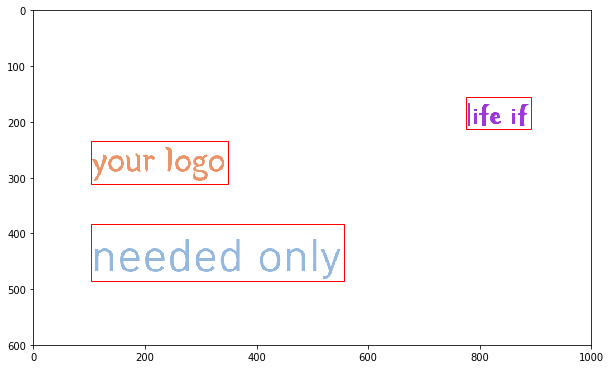

In [18]:
bbox_threshold = 0.9
X, Y, img_data = next(data_gen_train_ocr)
x_img = X.squeeze()
x_img[:, :, 0] += C.img_channel_mean[0]
x_img[:, :, 1] += C.img_channel_mean[1]
x_img[:, :, 2] += C.img_channel_mean[2]
x_img *= C.img_scaling_factor
x_img = x_img.astype(np.uint8)
plt.figure(figsize=(10, 13)) 
plt.imshow(x_img)
for bbox in img_data['bboxes']:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox['x1'], bbox['y1']), bbox['x2'] - bbox['x1'], bbox['y2'] - bbox['y1'], ec='r', fc='none'))
plt.show()

In [9]:
X, ratio = format_img(x_img[:, :, ::-1], C)

# get the feature maps and output from the RPN
[Y1, Y2, F] = model_rpn.predict(X)

In [10]:
R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)

In [11]:
# convert from (x1, y1, x2, y2) to (x, y, w, h)
R[:, 2] -= R[:, 0]
R[:, 3] -= R[:, 1]
# apply the spatial pyramid pooling to the proposed regions
bboxes = {}
probs = {}

In [12]:
R.shape

(300, 4)

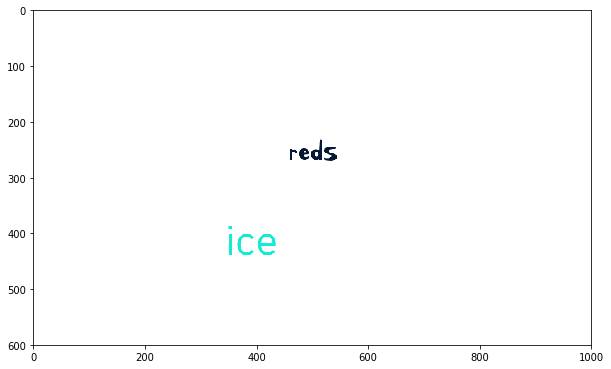

In [15]:
for jk in range(R.shape[0] // C.num_rois + 1):
    ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
    if ROIs.shape[1] == 0:
        break
        
    if jk == R.shape[0] // C.num_rois:
        # pad R        
        curr_shape = ROIs.shape
        target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
        ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
        ROIs_padded[:, :curr_shape[1], :] = ROIs
        ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
        ROIs = ROIs_padded
        
    [P_cls, P_regr] = model_classifier.predict([F, ROIs])
    
    for ii in range(P_cls.shape[1]):
        if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
            continue
            
        cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]
        
        if cls_name not in bboxes:
            bboxes[cls_name] = []
            probs[cls_name] = []
            
        (x, y, w, h) = ROIs[0, ii, :]
        cls_num = np.argmax(P_cls[0, ii, :])
        try:
            (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num: 4 * (cls_num + 1)]
            tx /= C.classifier_regr_std[0]
            ty /= C.classifier_regr_std[1]
            tw /= C.classifier_regr_std[2]
            th /= C.classifier_regr_std[3]
            x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
        except:
            pass
        
        bboxes[cls_name].append([C.rpn_stride * x, C.rpn_stride * y, C.rpn_stride * (x + w), C.rpn_stride * (y + h)])
        probs[cls_name].append(np.max(P_cls[0, ii, :]))

all_dets = []
x_img_copy = np.copy(x_img)
for key in bboxes.keys():
    bbox = np.array(bboxes[key])
    
    new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.1)
    for jk in range(new_boxes.shape[0]):
        (x1, y1, x2, y2) = new_boxes[jk, :]
        (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)
        cv2. rectangle(x_img_copy, (real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])), 2)
        textLabel = '{}: {}'.format(key, int(100 * new_probs[jk]))
        all_dets.append((key, 100 * new_probs[jk]))
        
        (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
        textOrg = (real_x1, real_y1-0)

        cv2.rectangle(x_img_copy, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
        cv2.rectangle(x_img_copy, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
        cv2.putText(x_img_copy, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

plt.figure(figsize=(10, 13))
plt.imshow(x_img_copy)
plt.show()